In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

Link towards reporting gsheet document:
https://docs.google.com/spreadsheets/d/1o0O9HGCUABQWF1C6uHw65veY9Axd3pATWwdG2WSpdf8/edit?usp=sharing

In [2]:
# Parameters corresponding to gsheet file
CLASS_NBR = 6
MODE = "cached" # "direct" or "cached"
KERNEL = "linear" # "linear" or "rbf"
LR = 0.4
C = 2

In [3]:
# Local parameters
BATCH_SIZE = 256
CNN_OUTPUT_DIR = os.path.join("..", "tmp", "cnn_output", "VGG16")
TARGET_W = 224
EPOCHS = 500
MODEL_DIR_DIRECT = None#"../tmp/estimator_svdd_naive_direct"
MODEL_DIR_CACHED = None#"../tmp/estimator_svdd_naive_cached"

# Input data

In [4]:
from data_utils import train_cnn_input_fn, test_cnn_input_fn, train_input_fn, test_input_fn

# Sanity check
train_cnn_input_fn(
    CLASS_NBR,
    CNN_OUTPUT_DIR
), test_cnn_input_fn(
    CLASS_NBR,
    CNN_OUTPUT_DIR
), train_input_fn(
    CLASS_NBR,
    TARGET_W
), test_input_fn(
    CLASS_NBR,
    TARGET_W
)

(<MapDataset shapes: (25088,), types: tf.float32>,
 <MapDataset shapes: ((25088,), <unknown>), types: (tf.float32, tf.int32)>,
 <MapDataset shapes: (224, 224, 3), types: tf.float32>,
 <MapDataset shapes: ((224, 224, 3), <unknown>), types: (tf.float32, tf.int32)>)

# Training

In [5]:
from estimator_svdd_naive import OCClassifier as SVDDClassifier

if MODE == "cached":
    input_fn_train = lambda: train_cnn_input_fn(CLASS_NBR, CNN_OUTPUT_DIR).shuffle(1000).repeat().batch(BATCH_SIZE)
    input_fn_test = lambda: test_cnn_input_fn(CLASS_NBR, CNN_OUTPUT_DIR).batch(BATCH_SIZE)
    train_hooks = []
    test_hooks = train_hooks
    MODEL_DIR = MODEL_DIR_CACHED
elif MODE == "direct":
    from vgg_network import VGG_Network
    from estimator_svdd_naive import _LoadPreTrainedWeightsVGG
    from data_utils import run_dataset_through_network
    
    net = VGG_Network(include_FC_head=False)
    
    def get_train_dataset(net, reuse=False):
        dataset = train_input_fn(CLASS_NBR, TARGET_W).batch(BATCH_SIZE)
        dataset = run_dataset_through_network(dataset, net, reuse=reuse)
        return dataset.repeat()
    
    def get_test_dataset(net, reuse=False):
        dataset = test_input_fn(CLASS_NBR, TARGET_W).batch(BATCH_SIZE)
        dataset = dataset.map(lambda img, label: img)
        dataset = run_dataset_through_network(dataset, net, reuse=reuse)
        return dataset
    
    input_fn_train = lambda: get_train_dataset(net, reuse=False)
    input_fn_test = lambda: get_test_dataset(net, reuse=False)
    train_hooks = [_LoadPreTrainedWeightsVGG(net)]
    test_hooks = train_hooks
    MODEL_DIR = MODEL_DIR_DIRECT
else:
    raise Exception("MODE unknown")
    
classifier = SVDDClassifier(
    c=C,
    kernel=KERNEL,
    learning_rate=LR,
    model_dir=MODEL_DIR,
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_train_distribute': None, '_task_id': 0, '_log_step_count_steps': 100, '_save_checkpoints_secs': 600, '_model_dir': '/tmp/tmpdkyi15te', '_save_checkpoints_steps': None, '_global_id_in_cluster': 0, '_evaluation_master': '', '_num_worker_replicas': 1, '_save_summary_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe5742c0e80>, '_session_config': None, '_tf_random_seed': None, '_is_chief': True, '_master': '', '_task_type': 'worker', '_keep_checkpoint_max': 5, '_service': None, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0}


In [6]:
classifier.train(
    input_fn=input_fn_train,
    steps=EPOCHS * 850 / BATCH_SIZE,
    hooks=train_hooks
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpdkyi15te/model.ckpt.
INFO:tensorflow:step = 0, loss = 1705851.1
INFO:tensorflow:global_step/sec: 3.22045
INFO:tensorflow:step = 100, loss = 226228.66 (31.050 sec)
INFO:tensorflow:global_step/sec: 3.33615
INFO:tensorflow:step = 200, loss = 202396.55 (29.973 sec)
INFO:tensorflow:global_step/sec: 3.38385
INFO:tensorflow:step = 300, loss = 181307.39 (29.550 sec)
INFO:tensorflow:global_step/sec: 3.22275
INFO:tensorflow:step = 400, loss = 153763.28 (31.030 sec)
INFO:tensorflow:global_step/sec: 3.27486
INFO:tensorflow:step = 500, loss = 123865.484 (30.535 sec)
INFO:tensorflow:global_step/sec: 3.16828
INFO:tensorflow:step = 600, loss = 124050.61 (31.563 sec)
INFO:tensorflow:global_step/sec: 3.28251
INFO:tens

# Predicting

In [7]:
predictions = classifier.predict(
    input_fn=input_fn_test,
    hooks=test_hooks
)

predictions_list = list(predictions)
predicted_scores = np.asarray(list(map(lambda p: p["predicted_scores"], predictions_list))).astype(np.int32)
predicted_classes = np.asarray(list(map(lambda p: p["predicted_classes"], predictions_list))).astype(np.int32)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdkyi15te/model.ckpt-1661
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [8]:
df = pd.DataFrame(predicted_classes)
df.plot.hist()

# Validation and metrics

In [9]:
# Test set
y_test = []
input_fn = test_cnn_input_fn(CLASS_NBR, CNN_OUTPUT_DIR).batch(1)
input_fn = input_fn.make_one_shot_iterator().get_next()
sess = tf.Session()
while True:
    try:
        data = sess.run(input_fn)
        y_test.append(data[1][0])
    except tf.errors.OutOfRangeError:
        break
y_test = np.asarray(y_test)
y_test.shape

(300,)

Confusion matrix, without normalization
[[117  33]
 [ 83  67]]


Accuracy     0.613333
Precision    0.670000
Recall       0.446667
f1-score     0.536000
dtype: float64

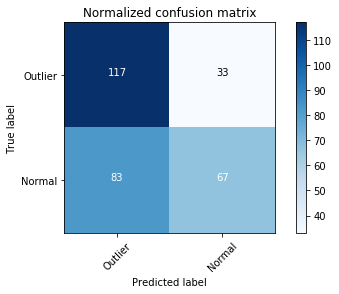

In [11]:
from validation import evaluation_summary
evaluation_summary(y_test, predicted_classes, plot_cm=True)